# Proyek Klasifikasi Gambar: Mammals Animals
- **Nama:** Muhammad Aziz Habiburrahim
- **Email:** azizhabibrahim@gmail.com
- **ID Dicoding:** mhabibr02

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflowjs  # Install TensorFlow.js untuk konversi model ke format JS

import os  # Mengelola path dan file
import zipfile  # Mengekstrak file ZIP
import shutil  # Memindahkan atau menghapus file/folder
import matplotlib.pyplot as plt  # Visualisasi grafik
import seaborn as sns  # Visualisasi grafik yang lebih interaktif
import numpy as np  # Operasi matematika dan array
import tensorflow as tf  # Framework deep learning
import tensorflowjs as tfjs  # Konversi model ke format TensorFlow.js
import random  # Membuat angka atau pilihan acak
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Augmentasi dan preprocessing gambar
from google.colab import files  # Upload dan download file di Colab
from PIL import Image  # Memproses dan membuka gambar
from collections import defaultdict  # Struktur data dictionary dengan default value
from google.colab import drive  # Mengakses Google Drive di Colab
from tensorflow.keras.applications import MobileNetV2  # Model pretrained MobileNetV2
from tensorflow.keras.models import Sequential  # Membuat model Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout  # Layer neural network
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Callback untuk simpan model terbaik & menghentikan training dini
from tensorflow.keras.models import load_model  # Memuat model yang tersimpan
from sklearn.metrics import confusion_matrix  # Membuat confusion matrix

## Data Preparation

### Data Loading

In [ ]:
drive.mount('/content/drive')  # Menghubungkan Google Drive

Mounted at /content/drive


### Data Preprocessing

In [ ]:
selected_classes = ['african_elephant', 'alpaca', 'polar_bear']
# Daftar kelas/golongan gambar yang akan digunakan untuk klasifikasi

for cls in selected_classes:
    os.makedirs(f'/content/dataset/train/{cls}', exist_ok=True)  # Membuat folder train untuk tiap kelas
    os.makedirs(f'/content/dataset/test/{cls}', exist_ok=True)   # Membuat folder test untuk tiap kelas

    src_folder = f'/content/drive/My Drive/Course/Images/mammals-animals/{cls}'  # Lokasi folder sumber di Google Drive
    all_files = os.listdir(src_folder)  # Mengambil semua nama file di folder sumber
    all_files.sort()  # Mengurutkan nama file (agar urutan konsisten)

    train_files = all_files[:800]  # 800 gambar pertama untuk data latih
    test_files = all_files[800:1000]  # 200 gambar berikutnya untuk data uji

    for file in train_files:
        shutil.copy(os.path.join(src_folder, file), f'/content/dataset/train/{cls}/{file}')  # Menyalin file ke folder train

    for file in test_files:
        shutil.copy(os.path.join(src_folder, file), f'/content/dataset/test/{cls}/{file}')  # Menyalin file ke folder test

In [ ]:
def print_images_resolution(directory):
    unique_sizes = set()  # Menyimpan resolusi gambar unik
    total_images = 0  # Menyimpan jumlah total gambar
    class_counts = defaultdict(int)  # Menyimpan jumlah gambar per kelas

    for subdir in os.listdir(directory):  # Loop setiap folder kelas
        subdir_path = os.path.join(directory, subdir)  # Path folder kelas
        image_files = os.listdir(subdir_path)  # Ambil semua file gambar
        num_images = len(image_files)  # Hitung jumlah gambar dalam kelas
        class_counts[subdir] = num_images  # Simpan jumlah gambar per kelas
        total_images += num_images  # Tambahkan ke total semua gambar

        for img_file in image_files:  # Loop setiap gambar
            img_path = os.path.join(subdir_path, img_file)  # Path gambar
            with Image.open(img_path) as img:  # Buka gambar
                unique_sizes.add(img.size)  # Simpan ukuran gambar

    print("Jumlah gambar per kelas:")
    for cls, count in class_counts.items():  # Cetak jumlah gambar per kelas
        print(f"{cls}: {count}")

    print("\nResolusi unik:")
    for size in unique_sizes:  # Cetak semua resolusi unik
        print(f"- {size}")

    print(f"\nTotal gambar: {total_images}")  # Cetak total gambar

print("Train set:")
print_images_resolution('/content/dataset/train')  # Cek data latih

print("\nTest set:")
print_images_resolution('/content/dataset/test')  # Cek data uji

Train set:
Jumlah gambar per kelas:
polar_bear: 356
african_elephant: 347
alpaca: 333

Resolusi unik:
- (256, 256)

Total gambar: 1036

Test set:
Jumlah gambar per kelas:
polar_bear: 20
african_elephant: 20
alpaca: 20

Resolusi unik:
- (256, 256)

Total gambar: 60


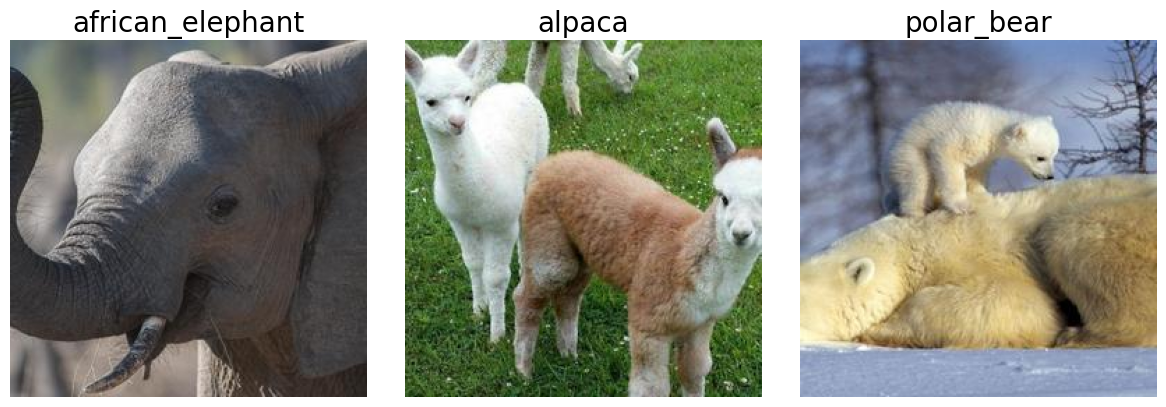

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Membuat figure dengan 3 baris × 5 kolom ukuran 15×9 inci
axes = axes.flatten()  # Mengubah array 2D axes menjadi 1D agar mudah diakses dengan index

for i, cls in enumerate(selected_classes):  # Loop setiap kelas yang dipilih
    img_path = os.path.join('/content/dataset/train', cls, os.listdir(f'/content/dataset/train/{cls}')[0])
    # Ambil path gambar pertama dari folder kelas
    img = Image.open(img_path)  # Membuka gambar
    axes[i].imshow(img)  # Menampilkan gambar di subplot
    axes[i].set_title(cls, fontsize=20)  # Menambahkan judul dengan nama kelas
    axes[i].axis('off')  # Menghilangkan sumbu x dan y

plt.tight_layout()  # Mengatur jarak antar subplot agar rapi
plt.show()  # Menampilkan plot

### Split Dataset

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Ukuran tinggi dan lebar gambar input (dalam piksel)
BATCH_SIZE = 32  # Jumlah sampel yang diproses dalam satu batch saat training

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi nilai piksel dari [0,255] menjadi [0,1]
    rotation_range=30,          # Rotasi gambar acak hingga 30 derajat
    width_shift_range=0.2,      # Pergeseran horizontal acak hingga 20% lebar gambar
    height_shift_range=0.2,     # Pergeseran vertikal acak hingga 20% tinggi gambar
    horizontal_flip=True,       # Membalik gambar secara horizontal secara acak
    brightness_range=[0.5, 1.5],# Variasi kecerahan acak (50% sampai 150%)
    validation_split=0.1        # Membagi 10% data untuk validasi
)

In [ ]:
val_test_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalisasi nilai piksel dari [0,255] menjadi [0,1]
    validation_split=0.1 # Membagi 10% data untuk validasi
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',        # Path folder dataset training
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Mengubah ukuran gambar menjadi 224×224 piksel
    batch_size=BATCH_SIZE,           # Jumlah gambar per batch (32)
    class_mode='categorical',        # Label dalam bentuk one-hot encoding
    subset='training'                # Menggunakan bagian data untuk training (90% dari total)
)

Found 934 images belonging to 3 classes.


In [ ]:
validation_generator = val_test_datagen.flow_from_directory(
    '/content/dataset/train',        # Path folder dataset training (dipakai juga untuk validasi)
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Mengubah ukuran gambar menjadi 224×224 piksel
    batch_size=BATCH_SIZE,           # Jumlah gambar per batch (32)
    class_mode='categorical',        # Label dalam bentuk one-hot encoding
    subset='validation'              # Menggunakan bagian data untuk validasi (10% dari total)
)

Found 102 images belonging to 3 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    '/content/dataset/test',         # Path folder dataset testing
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Mengubah ukuran gambar menjadi 224×224 piksel
    batch_size=BATCH_SIZE,           # Jumlah gambar per batch (32)
    class_mode='categorical',        # Label dalam bentuk one-hot encoding
    shuffle=False                    # Tidak mengacak urutan data (penting untuk evaluasi & prediksi)
)

Found 60 images belonging to 3 classes.


In [ ]:
os.makedirs('tflite', exist_ok=True)  # Membuat folder 'tflite' jika belum ada
class_names = list(train_generator.class_indices.keys())  # Mengambil daftar nama kelas dari generator training
label_file_path = 'tflite/label.txt'  # Path file untuk menyimpan label
with open(label_file_path, 'w') as f:  # Membuka file label.txt untuk ditulis
    for cls in class_names:            # Loop setiap nama kelas
        f.write(f"{cls}\n")            # Menuliskan nama kelas ke file (satu per baris)

In [ ]:
if os.path.exists(label_file_path):  # Mengecek apakah file label.txt sudah dibuat
    print(f"File {label_file_path} berhasil dibuat.")  # Konfirmasi file ditemukan
    with open(label_file_path, 'r') as f:  # Membuka file untuk dibaca
        print("Isi label.txt:")  # Menampilkan judul output
        print(f.read())  # Menampilkan isi file label.txt
else:
    print(f"Gagal membuat {label_file_path}.")  # Pesan jika file tidak ditemukan
    raise FileNotFoundError(f"{label_file_path} tidak ditemukan.")  # Menghentikan program dengan error

File tflite/label.txt berhasil dibuat.
Isi label.txt:
african_elephant
alpaca
polar_bear



In [ ]:
print(f"Train samples: {train_generator.samples}")        # Menampilkan jumlah total gambar di dataset training
print(f"Validation samples: {validation_generator.samples}")  # Menampilkan jumlah total gambar di dataset validasi
print(f"Test samples: {test_generator.samples}")          # Menampilkan jumlah total gambar di dataset testing

Train samples: 934
Validation samples: 102
Test samples: 60


## Modelling

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',       # Menggunakan bobot pretrained dari dataset ImageNet
    include_top=False,        # Menghapus lapisan fully connected paling atas
    input_shape=(224, 224, 3) # Ukuran input gambar (224x224 piksel, 3 channel RGB)
)
base_model.trainable = False  # Membekukan bobot base_model agar tidak ikut dilatih

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential([
    base_model,                                  # MobileNetV2 sebagai feature extractor (dibekukan)
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Layer konvolusi tambahan (32 filter, kernel 3x3)
    MaxPooling2D((2, 2)),                        # Layer pooling untuk mengurangi dimensi fitur
    GlobalAveragePooling2D(),                    # Meratakan fitur menjadi vektor
    Dense(128, activation='relu'),               # Fully connected layer dengan 128 neuron dan ReLU
    Dropout(0.5),                                # Dropout 50% untuk mencegah overfitting
    Dense(3, activation='softmax')              # Output layer dengan 3 neuron (jumlah kelas), aktivasi softmax
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Optimizer Adam dengan learning rate 0.001
    loss='categorical_crossentropy',                         # Loss function untuk klasifikasi multi-kelas (one-hot)
    metrics=['accuracy']                                     # Metrik evaluasi akurasi
)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_sequential.h5',  # Nama file untuk menyimpan model terbaik
    monitor='val_loss',          # Metrik yang dipantau adalah loss pada data validasi
    save_best_only=True,         # Hanya menyimpan model jika val_loss membaik
    mode='min'                   # val_loss terbaik adalah nilai terkecil
)

early_stopping = EarlyStopping(
    monitor='val_loss',          # Metrik yang dipantau adalah loss pada data validasi
    patience=5,                  # Hentikan training jika tidak ada perbaikan selama 5 epoch berturut-turut
    restore_best_weights=True    # Mengembalikan bobot model ke versi terbaik sebelum overfitting
)

In [ ]:
history = model.fit(
    train_generator,                               # Data latih
    steps_per_epoch=train_generator.samples // 32, # Jumlah batch per epoch
    epochs=20,                                     # Maksimal 20 epoch training
    validation_data=validation_generator,          # Data validasi
    validation_steps=validation_generator.samples // 32,  # Jumlah batch validasi per epoch
    callbacks=[checkpoint, early_stopping]         # Callback untuk simpan model terbaik & hentikan lebih awal
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7535 - loss: 0.6227

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7574 - loss: 0.6139 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 2/20
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 1.0000 - loss: 0.0139

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 7.8086e-04
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9740 - loss: 0.1022 - val_accuracy: 0.9896 - val_loss: 0.0239
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0996 - val_accuracy: 0.9896 - val_loss: 0.0304
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9568 - loss: 0.1606 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9778 - loss: 0.0477 - val_accuracy: 1.0000 - val_loss: 0.0027


## Evaluasi dan Visualisasi

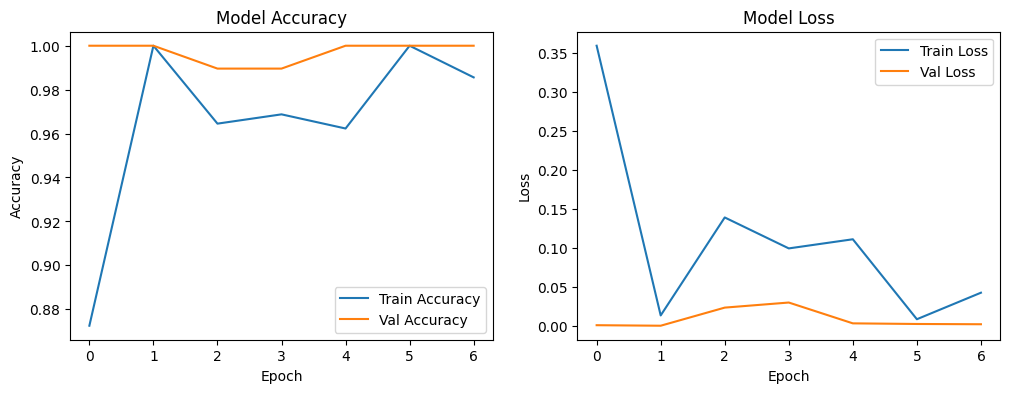

In [ ]:
plt.figure(figsize=(12, 4))  # Membuat canvas plot berukuran 12x4 inci

# Plot Akurasi
plt.subplot(1, 2, 1)  # Subplot pertama (1 baris, 2 kolom, posisi 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')      # Akurasi data latih
plt.plot(history.history['val_accuracy'], label='Val Accuracy')    # Akurasi data validasi
plt.title('Model Accuracy')  # Judul grafik akurasi
plt.xlabel('Epoch')          # Label sumbu X
plt.ylabel('Accuracy')       # Label sumbu Y
plt.legend()                 # Menampilkan legenda

# Plot Loss
plt.subplot(1, 2, 2)  # Subplot kedua (posisi 2)
plt.plot(history.history['loss'], label='Train Loss')              # Loss data latih
plt.plot(history.history['val_loss'], label='Val Loss')            # Loss data validasi
plt.title('Model Loss')     # Judul grafik loss
plt.xlabel('Epoch')         # Label sumbu X
plt.ylabel('Loss')          # Label sumbu Y
plt.legend()                # Menampilkan legenda

# Simpan dan tampilkan plot
plt.savefig('accuracy_loss_plot.png')  # Simpan grafik sebagai file PNG
plt.show()                             # Tampilkan grafik di output

In [ ]:
model = load_model('best_model_sequential.h5')  # Memuat kembali model terbaik yang telah disimpan selama training

In [ ]:
class_names = list(train_generator.class_indices.keys())  # Mengambil daftar nama kelas dari train_generator
print(f"Class Names (dari train_generator): {class_names}")  # Menampilkan nama-nama kelas

Class Names (dari train_generator): ['african_elephant', 'alpaca', 'polar_bear']


In [ ]:
evaluation = model.evaluate(test_generator, steps=test_generator.samples // 32)
# Mengevaluasi performa model menggunakan data test_generator
# steps ditentukan berdasarkan jumlah batch yang akan dievaluasi

print(f"Test Loss: {evaluation[0]:.4f}")   # Menampilkan nilai loss pada dataset uji
print(f"Test Accuracy: {evaluation[1]:.4f}")  # Menampilkan akurasi pada dataset uji

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9688 - loss: 0.1153
Test Loss: 0.1153
Test Accuracy: 0.9688


In [ ]:
def load_and_preprocess_image(img_path):
    # Membuka gambar dan mengubah ukurannya menjadi 224×224 piksel
    img = Image.open(img_path).resize((224, 224))

    # Mengubah gambar menjadi array NumPy dan menormalisasi piksel ke rentang 0-1
    img_array = np.array(img) / 255.0

    # Menambahkan dimensi batch agar sesuai dengan input model
    return np.expand_dims(img_array, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


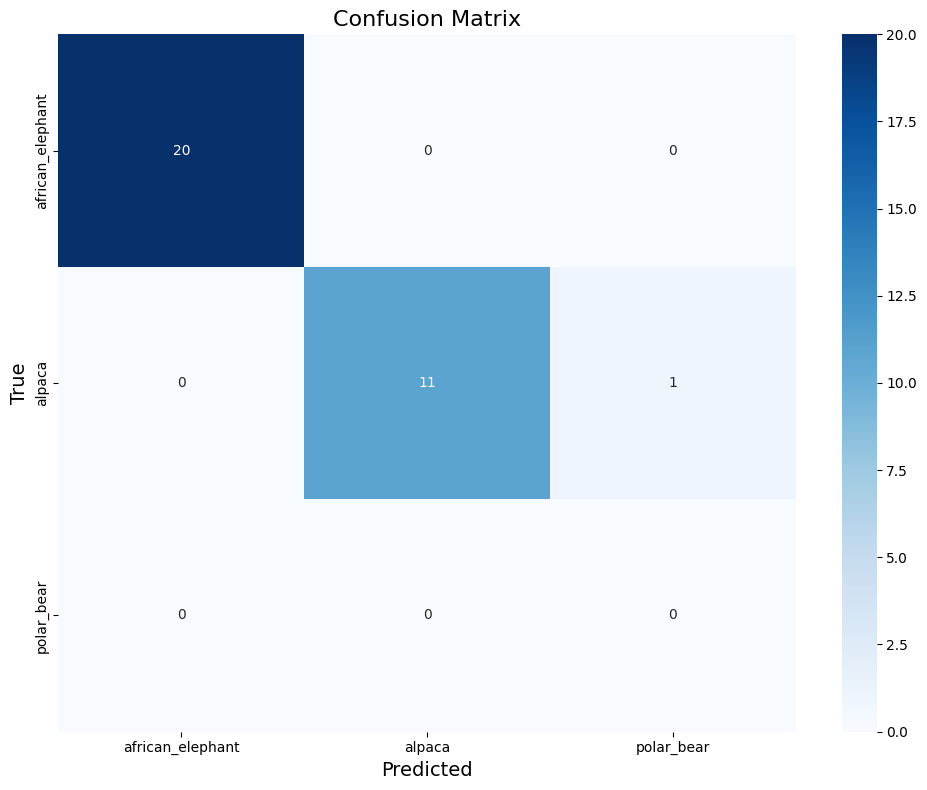

In [ ]:
# Reset generator agar prediksi dimulai dari awal
test_generator.reset()

# Prediksi semua batch
y_pred_probs = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes[:len(y_pred)]

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sample 1: True Class: african_elephant, Predicted Class: african_elephant, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Sample 2: True Class: alpaca, Predicted Class: alpaca, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Sample 3: True Class: polar_bear, Predicted Class: polar_bear, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Sample 4: True Class: african_elephant, Predicted Class: african_elephant, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Sample 5: True Class: alpaca, Predicted Class: alpaca, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Sample 6: True Class: polar_bear, Predicted Class: polar_bear, Confidence: 100.00%


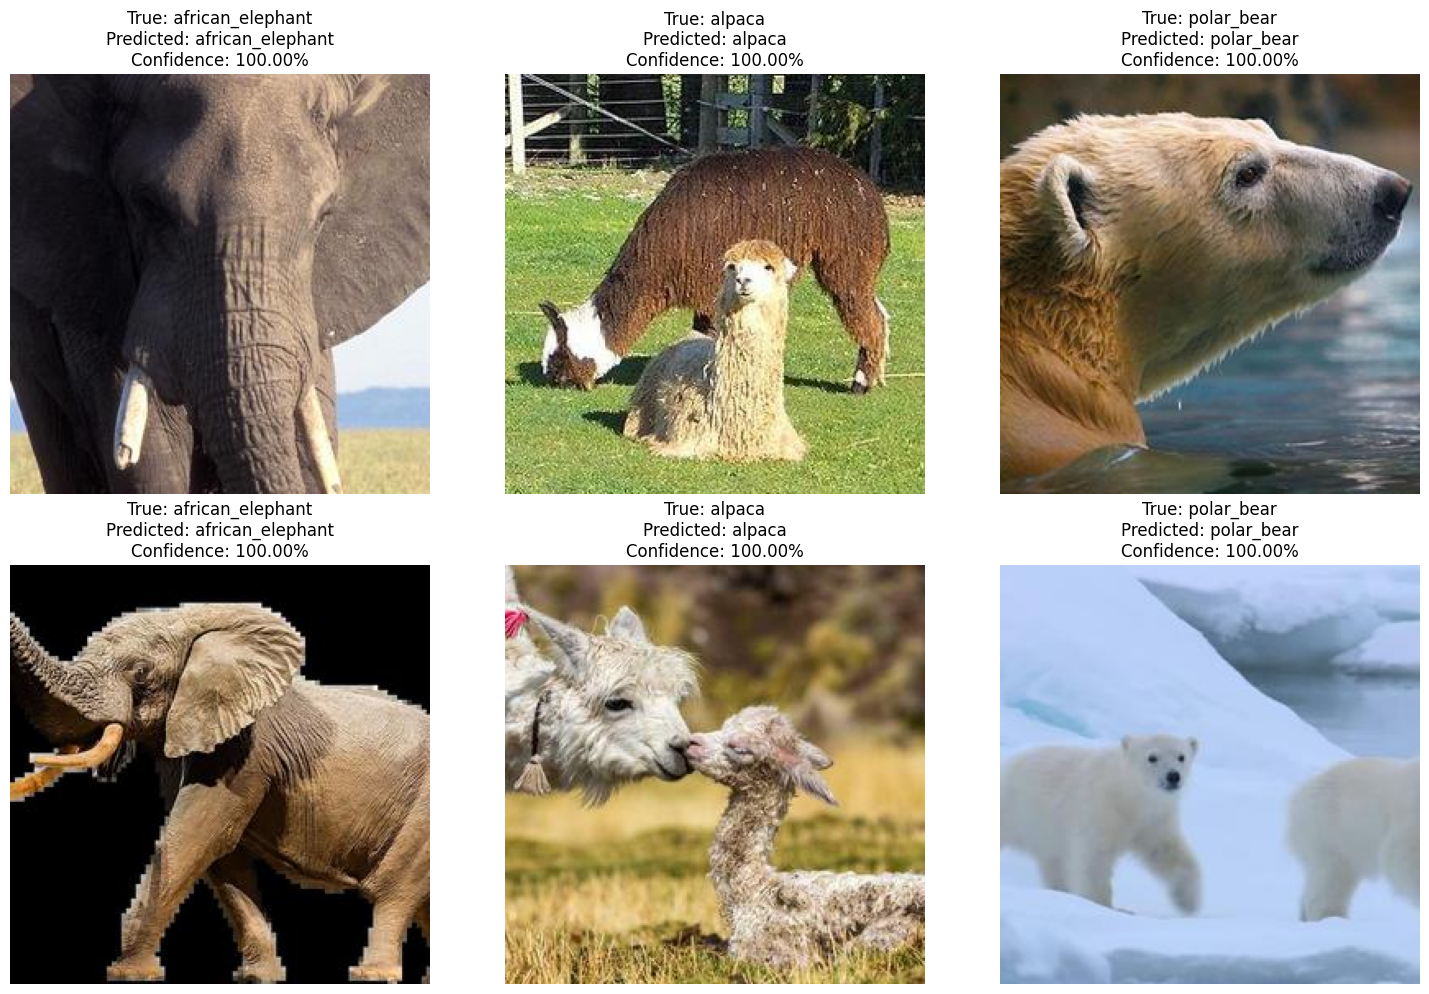

In [ ]:
test_dir = '/content/dataset/test'  # Folder berisi dataset test
num_samples = 6  # Jumlah sampel gambar yang akan diuji
correct_prediction_found = False  # Flag untuk menandai jika ada prediksi benar
correct_img_path = None  # Menyimpan path gambar prediksi benar
correct_true_cls = None  # Menyimpan kelas asli gambar prediksi benar
correct_pred_cls = None  # Menyimpan kelas prediksi gambar benar
correct_confidence = None  # Menyimpan nilai confidence prediksi benar

plt.figure(figsize=(15, 10))  # Membuat figure untuk plot hasil
for i in range(num_samples):  # Loop untuk ambil beberapa sampel
    cls = class_names[i % len(class_names)]  # Ambil nama kelas secara berurutan
    img_files = os.listdir(f'{test_dir}/{cls}')  # Ambil semua file gambar di kelas tersebut
    img_file = random.choice(img_files)  # Pilih satu gambar acak
    img_path = os.path.join(test_dir, cls, img_file)  # Gabungkan path folder dan nama file

    test_img = load_and_preprocess_image(img_path)  # Load & preprocess gambar
    prediction = model.predict(test_img)  # Prediksi kelas gambar
    predicted_class = class_names[np.argmax(prediction)]  # Ambil nama kelas hasil prediksi
    confidence = np.max(prediction)  # Ambil nilai confidence tertinggi

    # Simpan informasi prediksi benar pertama yang ditemukan
    if cls == predicted_class and not correct_prediction_found:
        correct_prediction_found = True
        correct_img_path = img_path
        correct_true_cls = cls
        correct_pred_cls = predicted_class
        correct_confidence = confidence

    # Tampilkan gambar di grid
    plt.subplot(2, 3, i+1)
    plt.imshow(Image.open(img_path))
    plt.title(f"True: {cls}\nPredicted: {predicted_class}\nConfidence: {confidence:.2%}")
    plt.axis('off')

    # Cetak info ke terminal
    print(f"Sample {i+1}: True Class: {cls}, Predicted Class: {predicted_class}, Confidence: {confidence:.2%}")

plt.tight_layout()  # Atur layout agar tidak tumpang tindih
plt.savefig('inference_result.png')  # Simpan hasil plot ke file
plt.show()  # Tampilkan plot di layar

Prediksi benar ditemukan untuk bukti inferensi:
True Class: african_elephant, Predicted Class: african_elephant, Confidence: 100.00%


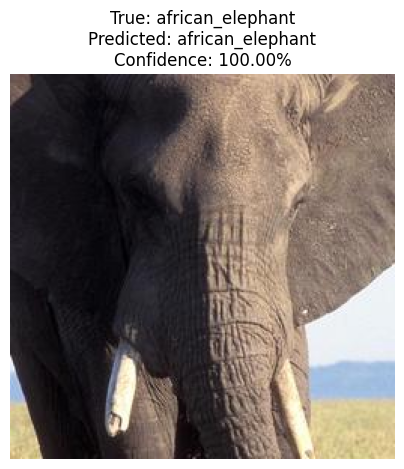

In [ ]:
if correct_prediction_found: # Jika ada prediksi benar yang ditemukan
    print("Prediksi benar ditemukan untuk bukti inferensi:") # Info ke terminal
    print(f"True Class: {correct_true_cls}, Predicted Class: {correct_pred_cls}, Confidence: {correct_confidence:.2%}")

    plt.figure(figsize=(5, 5)) # Buat figure untuk menampilkan bukti gambar prediksi benar
    plt.imshow(Image.open(correct_img_path)) # Tampilkan gambar prediksi benar
    plt.title(f"True: {correct_true_cls}\nPredicted: {correct_pred_cls}\nConfidence: {correct_confidence:.2%}")  # Judul berisi info kelas & confidence
    plt.axis('off') # Hilangkan axis
    plt.savefig('correct_inference.png') # Simpan gambar bukti ke file
    plt.show() # Tampilkan gambar

else: # Jika tidak ada prediksi benar yang ditemukan
    print("Peringatan: Tidak ada prediksi benar setelah 6 sampel. Periksa model atau data.")

## Konversi Model

In [ ]:
model = tf.keras.models.load_model('best_model_sequential.h5')
# Memuat kembali model terbaik yang sudah disimpan sebelumnya (format .h5)

tf.saved_model.save(model, 'saved_model')
# Menyimpan model ke format SavedModel TensorFlow (folder `saved_model`)
# Format ini lebih umum dipakai untuk deployment seperti TensorFlow Serving, TFLite, dsb.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Membuat converter untuk mengubah model Keras menjadi format TensorFlow Lite

tflite_model = converter.convert()
# Melakukan proses konversi, hasilnya berupa bytecode model TFLite

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
# Menyimpan model TFLite ke file `model.tflite` di folder `tflite`

Saved artifact at '/tmp/tmpw1ojrwuv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135068589535888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589539152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589533584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589538000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589535504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589536080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589536656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589536464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589538384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135068589538576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1350685895372

In [ ]:
class_names = list(train_generator.class_indices.keys())
# Mengambil daftar nama kelas dari train_generator

with open('tflite/label.txt', 'w') as f:
    for cls in class_names:
        f.write(f"{cls}\n")
# Menulis setiap nama kelas ke file `tflite/label.txt`, satu kelas per baris

In [ ]:
!tensorflowjs_converter --input_format keras best_model_sequential.h5 tfjs_model
# Menjalankan perintah konversi model Keras (.h5) menjadi format TensorFlow.js
# `--input_format keras` → Menandakan input adalah model Keras
# `best_model_sequential.h5` → File model Keras yang akan dikonversi
# `tfjs_model` → Folder tujuan untuk menyimpan model dalam format TensorFlow.js

2025-08-09 11:02:35.678942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754737355.738999    7147 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754737355.757761    7147 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754737355.807290    7147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754737355.807393    7147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754737355.807403    7147 computation_placer.cc:177] computation placer alr

In [ ]:
!pip freeze > requirements.txt
# Menyimpan daftar semua library Python beserta versinya yang terinstall ke file requirements.txt
# Berguna untuk mereplikasi environment di tempat lain

from google.colab import files
files.download('requirements.txt')
# Menggunakan modul bawaan Colab untuk mengunduh file ke komputer lokal
# Di sini file requirements.txt akan otomatis terdownload

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
readme_content = """
# Image Classification Project Belajar Fundamental Deep Learning

## Overview
Pada project ini mengembangkan model CNN berbasis transfer learning untuk mengklasifikasikan gambar Mamalia Hewan
antara lain; african_elephant, alpaca dan polar_bear. Bahasa Pemrograman yang digunakan ialah Python.

## Dataset
- **Nama** : Mammals Animals
- **Sumber**: Kaggle
- **Kelas**: african_elephant, alpaca, polar_bear.
- **Jumlah** (Train 934, Validation 102, Test 60)
- **Resolusi**: (256, 256)

## Metodologi
- **Arsitektur**: MobileNetV2, Conv2D, Pooling, dan Dense
- **Augmentasi**: Rotasi, Translasi, Flip Horizontal, Penyesuaian Kecerahan
- **Callbacks**: ModelCheckpoint, EarlyStopping
- **Inferensi**: Dilakukan menggunakan saved_model, bukti disimpan di `confusion_matrix.png`, `correct_inference.png`,
`inference_result.png` dan `train_image.png`

## Struktur
project/
├── saved_model/
│ ├── assets/
│ │ ├── `accuracy_loss_plot.png`
│ │ ├── `confusion_matrix.png`
│ │ ├── `correct_inference.png`
│ │ ├── `inference_result.png`
│ │ └── `train_image.png`
│ ├── variables/
│ │ ├── `variables.data-00000-of-00001`
│ │ └── `variables.index`
│ ├── `fingerprint.pb`
│ ├── `saved_model.pb`
│ └── `best_model_sequential.h5`
├── tfjs_model/
│ ├── `group1-shard1of3.bin`
│ ├── `group1-shard2of3.bin`
│ ├── `group1-shard3of3.bin`
│ └── `model.json`
├── tflite/
│ ├── `label.txt`
│ └── `model.tflite`
├── `notebook.ipynb`
├── `readme.md`
└── `requirements.txt`

## Hasil
- **Accuracy**: 96.98%
- **Visualisasi**: `accuracy_loss_plot.png`
- **Bukti Inferensi**: `inference_result.png` dan `correct_inference.png`
- **Analisis**: `confusion_matrix.png`
"""
with open('README.md', 'w') as f:
    f.write(readme_content)
